# SIS Lens

This part interpolates the amplification factor for the SIS lens using the data obtained from the MATHEMATICA file.

~ Saif 8/21

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt
from gw_lens_dir.overlap_lensing_sis import overlap_sis 
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
def cleanData(filePath = '/Users/saifali/Desktop/gwlensing/data/', 
              fileName = None):
    
    with open(filePath + fileName) as f:
        read = f.readlines()
    results_temp = [float(s) for s in read[0][1:-1].split(',')]
    results = [i for n, i in enumerate(results_temp) if i not in results_temp[:n]]
    
    return np.array(results)

freq = cleanData(fileName = 'freq_interpolate_y_0.5.txt')
Fsis_abs = cleanData(fileName = 'abs_ampfact_interpolate_y_0.5.txt')

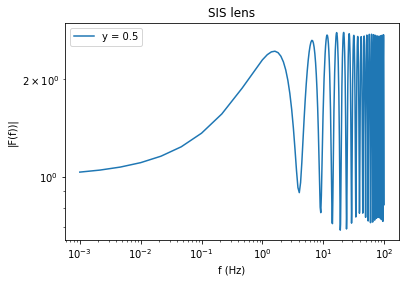

In [3]:
plt.loglog(freq, Fsis_abs, label = f"y = 0.5")
plt.title("SIS lens")
plt.xlabel('f (Hz)')
plt.ylabel('|F(f))|')
plt.legend()

In [24]:
def F_interp(freq, Fsis, freq_cut_val = 2, seed = None, random_size = 20):
    
    np.random.seed(seed)
    #[freq_cut_val] = Hz
    
    freq_cut = freq[freq < freq_cut_val]
    Fsis_cut = Fsis[:len(freq_cut)]
    
    
    '''
    freq_cut = freq
    Fsis_cut = Fsis
    '''
    
    
    if Fsis[0] > 0:
        plt.loglog(freq_cut, Fsis_cut, marker = 'x')
    else:
        plt.plot(freq_cut, Fsis_cut, marker = 'x')
    
    freq_interp = np.random.uniform(low = freq_cut[0], high = freq_cut[-1], size = random_size)
    Fsis_interp = np.zeros_like(freq_interp)

    for i in range(random_size):
        Fsis_interp_temp = interp1d(freq_cut, Fsis_cut)
        Fsis_interp[i] = Fsis_interp_temp(freq_interp[i])
    
    if Fsis[0] > 0:
        plt.loglog(freq_interp, Fsis_interp, '.', label = 'interpolated')
    else:
        plt.semilogx(freq_interp, Fsis_interp, '.', label = 'interpolated')
    plt.legend()
    
    return freq_interp, Fsis_interp

Text(0, 0.5, '|F(f)|')

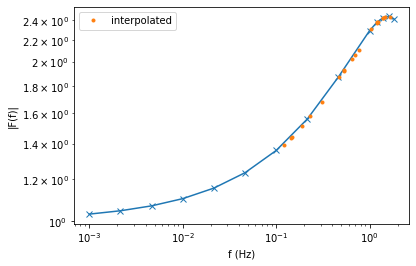

In [25]:
# absolute value of amplification factor
F_interp(freq = freq, Fsis = Fsis_abs)
plt.xlabel('f (Hz)')
plt.ylabel('|F(f)|')

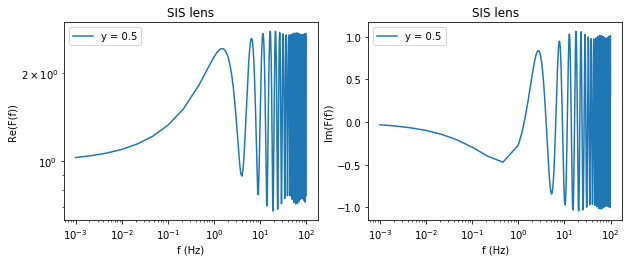

In [26]:
freq = cleanData(fileName = 'freq_interpolate_y_0.5.txt')
Fsis_real = cleanData(fileName = 're_ampfact_interpolate_y_0.5.txt')
Fsis_im = cleanData(fileName = 'im_ampfact_interpolate_y_0.5.txt')

plt.figure(figsize = (10, 8))
plt.subplot(2, 2, 1)
plt.loglog(freq, Fsis_real, label = "y = 0.5")
plt.title("SIS lens")
plt.xlabel('f (Hz)')
plt.ylabel('Re(F(f))')
plt.legend()

plt.subplot(2, 2, 2)
plt.semilogx(freq, Fsis_im, label = "y = 0.5")
plt.title("SIS lens")
plt.xlabel('f (Hz)')
plt.ylabel('Im(F(f))')
plt.legend()

Text(0, 0.5, 'Im(F(f))')

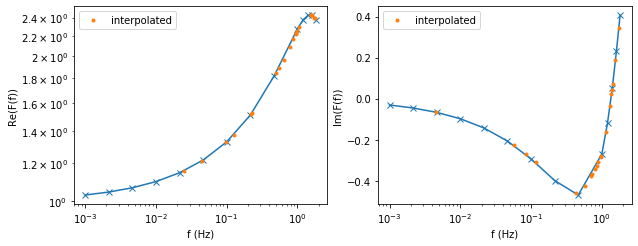

In [27]:
plt.figure(figsize = (10, 8))

plt.subplot(2, 2, 1)
F_interp(freq, Fsis_real)
plt.xlabel('f (Hz)')
plt.ylabel('Re(F(f))')
plt.subplot(2, 2, 2)
F_interp(freq, Fsis_im)
plt.xlabel('f (Hz)')
plt.ylabel('Im(F(f))')

## Trying the infinite sum from this [paper](https://arxiv.org/pdf/2112.07012.pdf)

In [2]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 
def my_lin(lb, ub, steps, spacing = 1.5):
    span = (ub-lb)
    dx = 1.0 / (steps-1)
    return np.array([lb + (i * dx) ** spacing * span for i in range(steps)])
#my_lin(1e2 * solar_mass, 1e6 * solar_mass, 20)/solar_mass

In [3]:
M_lz_source_range = my_lin(1e2 * solar_mass, 1e4 * solar_mass, 10)
print(M_lz_source_range / solar_mass)
print(M_lz_source_range)

[  100.           466.66666667  1137.08994574  2005.25588833
  3033.33333333  4199.45795875  5488.87743412  6890.7616984
  8396.71956592 10000.        ]
[0.00049262 0.00229891 0.00560158 0.00987837 0.01494293 0.02068754
 0.02703953 0.03394555 0.04136426 0.04926241]


In [11]:
from mpmath import *

solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
year = 31557600 #[year] = sec
mp.pretty = True 

freq = my_lin(0.001, 250, 500)

def Fsis(f):
    
    ml = 1e2 * solar_mass
    w = 8 * pi * ml * f
    y = 0.5
    
    pre_factor = exp(1j * (w / 2) * (y**2 + 2 * (y + 0.5))) 
    func = lambda n: (gamma(1 + n / 2) / fac(n)) * (2 * w * exp(1j * 3 * (pi / 2))) ** (n / 2) * hyp1f1(1 + n / 2, 1, -1j * (w / 2) * y ** 2)
    
    series_sum = nsum(func, [0, inf])
    
    return pre_factor * series_sum

Fsis_series = np.zeros_like(freq)

for i in range(len(freq)):
    Fsis_series[i] = np.abs(Fsis(freq[i]))

In [12]:
peaks, _ = find_peaks(Fsis_series) 
freq_at_peaks = freq[peaks][0]
print(freq_at_peaks)

156.6473427174991


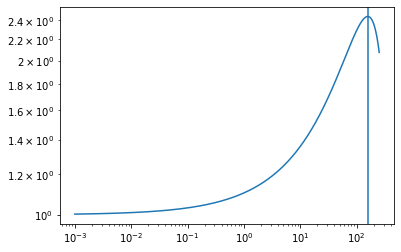

In [13]:
plt.loglog(freq, Fsis_series)
plt.axvline(x = freq_at_peaks)

## Overlap analysis for the SIS lens

In [14]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
year = 31557600 #[year] = sec

initial_params_source = {
    'theta_s_source' : 0.0, 
    'phi_s_source' : 0.0, 
    'theta_l_source' : 0.0, 
    'phi_l_source' : 0.0, 
    'mcz_source' : 18.79 * solar_mass, 
    'dist_source': 1.58 * giga_parsec, 
    'eta_source' : 0.25, 
    't0' : 0.0, 
    'phi_0' : 0.0,
    'M_lz_source':1e4 * solar_mass,
    'y_source': 0.5
}

initial_params_template = {
    'theta_s_temp' : 0.0, 
    'phi_s_temp' : 0.0, 
    'theta_l_temp' : 0.0, 
    'phi_l_temp' : 0.0, 
    'mcz_temp' : 18.79 * solar_mass, 
    'dist_temp': 1.58 * giga_parsec, 
    'eta_temp' : 0.25, 
    #'tc' : 0.0, 
    #'phi_c' : 0.0,
}

In [15]:
overlap_sis_init = overlap_sis(params_source = initial_params_source,
                              params_temp = initial_params_template) 

In [16]:
overlap_sis_init.limit(initial_params_source, initial_params_template)

(20, 101.84620327015129, 101.84620327015129, 101.84620327015129)

In [17]:
overlap_sis_init.get_f_transition()

1.5677514909578671

In [18]:
overlap_sis_init.overlap(x = [0, 0])

/Users/saifali/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


-0.8650773069805713

In [19]:
f_trans = np.zeros_like(M_lz_source_range)
for i in range(len(M_lz_source_range)):
    params_source = initial_params_source
    params_source['M_lz_source'] = M_lz_source_range[i]
    overlap_sis_initialized = overlap_sis(params_source = params_source,
                                          params_temp = initial_params_template)
    f_trans[i] = overlap_sis_initialized.get_f_transition()

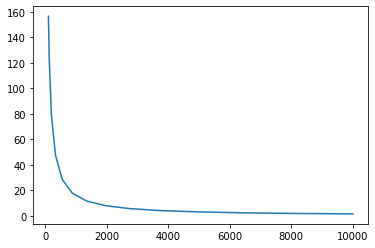

In [70]:
plt.plot(M_lz_source_range / solar_mass, f_trans)

In [97]:
M_lz_source_range[f_trans < 20] / solar_mass, f_trans[f_trans < 20]

(array([  879.30029155,  1337.5       ,  1947.2303207 ,  2730.13848397,
         3707.87172012,  4902.07725948,  6334.40233236,  8026.4941691 ,
        10000.        ]),
 array([17.8472787 , 11.73521793,  8.08875539,  5.76205031,  4.22055395,
         3.2235096 ,  2.46583566,  1.95328051,  1.56775149]))

In [14]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec

def mag(ml, y, lens):
    
    if lens == 'pm':
        mu_plus = np.abs(0.5 + (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
        mu_minus = np.abs(0.5 - (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
    
    elif lens == 'sis':
        mu_plus = np.abs(1 + 1 / y)
        mu_minus = np.abs(-1 + 1 / y)
    
    return mu_plus, mu_minus

def td(ml, y, lens):
    
    if lens == 'pm':
        first_term = (y * (y ** 2 + 4) ** 0.5) / 2
        second_term = np.log(((y ** 2 + 4) ** 0.5 + y) / ((y ** 2 + 4) ** 0.5 - y))
        tds = 4 * ml * (first_term + second_term)
    
    elif lens == 'sis':
        tds = 8 * ml * y
    
    return tds

In [24]:
M_lz_source_range_log = np.logspace(2.8, 5, 10) * solar_mass
t_del = np.zeros_like(M_lz_source_range_log)
for i in range(len(M_lz_source_range_log)):
    t_del[i] = td(M_lz_source_range_log[i], 0.5, 'sis')
M_lz_source_range_log[t_del < 0.05] / solar_mass, t_del[t_del < 0.05]

(array([ 630.95734448, 1107.75685051, 1944.86243894]),
 array([0.01243299, 0.02182831, 0.03832344]))

Text(0.5, 0, '$M_L$')

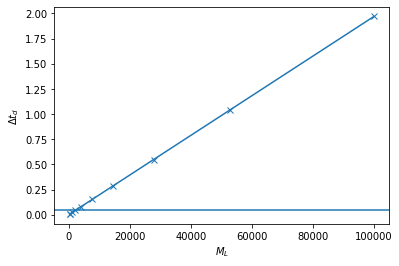

In [21]:
plt.plot(M_lz_source_range_log / solar_mass, t_del, marker = 'x')
plt.axhline(0.05)
plt.ylabel(r'$\Delta t_d$')
plt.xlabel('$M_L$')
#plt.ylim(0, 1)

In [2]:
overlap_sis = pd.read_csv("/Users/saifali/Desktop/gwlensing/data/overlap_sis_ml_y=0.5_mcz=18.79.csv")

In [9]:
overlap_sis.loc[1] = ([0.0015578141103958897, 0.9904197081977452, 0.001594235465112513, 0.41154435946099954])
overlap_sis.loc[2] = ([0.002350103892669491, 0.9081071306279737, -0.0010108586710720075, -0.5885921180055249])
overlap_sis.loc[3] = ([0.0035453448967263067, 0.9049845295431442, -0.0006819010254559508, -0.26933716627004817])
overlap_sis.loc[4] = ([0.078076,  0.865753,  0.000034,  0.009876])
overlap_sis.loc[5] = ([0.196117,  0.865745,  0.000017,  0.006695])
overlap_sis.loc[6] = ([0.492624,  0.866056,  0.000006,  0.002081])
overlap_sis = overlap_sis.reindex([1, 2, 3, 4, 5, 6])
overlap_sis

,M_lz,overlap,tc,phi_c
1,0.001558,0.990420,0.001594,0.411544
2,0.002350,0.908107,-0.001011,-0.588592
3,0.003545,0.904985,-0.000682,-0.269337
4,0.078076,0.865753,0.000034,0.009876
5,0.196117,0.865745,0.000017,0.006695
6,0.492624,0.866056,0.000006,0.002081


In [10]:
M_l = np.array(overlap_sis['M_lz'])
match = np.array(overlap_sis['overlap'])
np.c_[M_l / solar_mass, 1 - match]

array([[3.16227766e+02, 9.58029180e-03],
       [4.77058270e+02, 9.18928694e-02],
       [7.19685673e+02, 9.50154705e-02],
       [1.58490021e+04, 1.34247000e-01],
       [3.98106811e+04, 1.34255000e-01],
       [9.99999846e+04, 1.33944000e-01]])

In [11]:
td_range = td(M_l, 0.5, 'sis')
td_range

array([0.00623126, 0.00940042, 0.01418138, 0.312304  , 0.784468  ,
       1.970496  ])

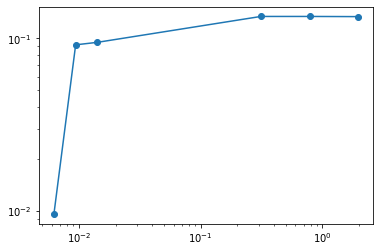

In [13]:
plt.loglog(td_range, 1 - match, marker = 'o')